<h1>Iris classification</h1>

Here we see how to encode real vectors as amplitude vectors (amplitude encoding) and train the model to recognize the first two classes of flowers in the Iris dataset

In [1]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer

To encode real-valued vectors into the amplitudes of a quantum state, we use a 2-qubit simulator.

In [2]:
dev = qml.device("default.qubit", wires=2)

State preparation is not as simple as when we represent a bitstring with a basis state. Every input x has to be translated into a set of angles which can get fed into a small routine for state preparation. To simplify things a bit, we will work with data from the positive subspace, so that we can ignore signs (which would require another cascade of rotations around the z axis).

The circuit is coded according to the scheme in Möttönen, et al. (2004), or—as presented for positive vectors only—in Schuld and Petruccione (2018). We had to also decompose controlled Y-axis rotations into more basic circuits following Nielsen and Chuang (2010).

In [3]:
@ct.electron
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [4]:
@ct.electron
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Note that the default.qubit simulator provides a shortcut to statepreparation with the command qml.QubitStateVector(x, wires=[0, 1]). However, some devices may not support an arbitrary state-preparation routine.

Since we are working with only 2 qubits now, we need to update the layer function as well.

In [5]:
@ct.electron
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

The variational classifier model and its cost remain essentially the same, but we have to reload them with the new state preparation and layer functions.

In [6]:
@ct.electron
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [7]:
@ct.electron
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [8]:
@ct.electron
def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias

<h3>Cost</h3>

In supervised learning, the cost function is usually the sum of a loss function and a regularizer. We use the standard square loss that measures the distance between target labels and model predictions.

In [9]:
@ct.electron
def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [10]:
@ct.electron
def load_features(data):
    # pad the vectors to size 2^2 with constant values
    X = data[:, 0:2]
    print("First X sample (original)  :", X[0])

    padding = 0.3 * np.ones((len(X), 1))
    X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
    print("First X sample (padded)    :", X_pad[0])

    # normalize each input
    normalization = np.sqrt(np.sum(X_pad ** 2, -1))
    X_norm = (X_pad.T / normalization).T
    print("First X sample (normalized):", X_norm[0])

    # angles for state preparation are new features
    features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
    Y = data[:, -1]
    return features,Y,X,X_norm,X_pad

<h3>Data</h3>

We then load the Iris data set. There is a bit of preprocessing to do in order to encode the inputs into the amplitudes of a quantum state. In the last preprocessing step, we translate the inputs x to rotation angles using the get_angles function we defined above.


<p>The Iris dataset can be downloaded
<span class="html"><a href="https://raw.githubusercontent.com/XanaduAI/qml/master/demonstrations/variational_classifier/data/iris_classes1and2_scaled.txt" download="parity.txt" target="_blank">here</a></span> and should be placed
in the subfolder <code class="docutils literal notranslate"><span class="pre">./iris_classes1and2_scaled.txt</span></code>.</p>


In [11]:
data = np.loadtxt("./iris_classes1and2_scaled.txt")

features,Y,X,X_norm,X_pad = load_features(data)

print("First features sample      :", features[0])


First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


These angles are our new features, which is why we have renamed X to “features” above. Let’s plot the stages of preprocessing and play around with the dimensions (dim1, dim2). Some of them still separate the classes well, while others are less informative.

Note: To run the following code you need the matplotlib library.

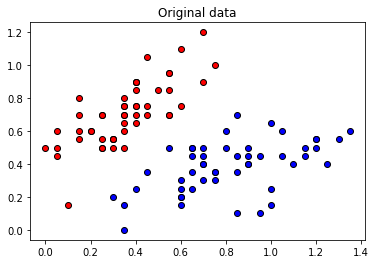

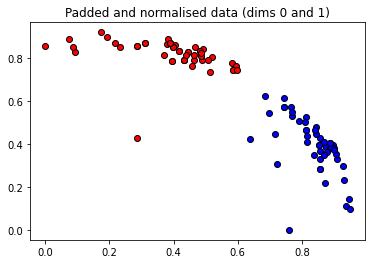

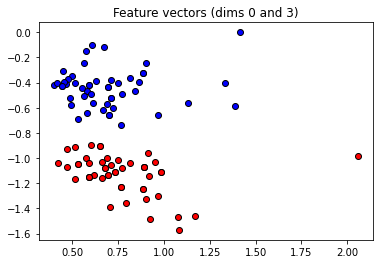

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()


This time we want to generalize from the data samples. To monitor the generalization performance, the data is split into training and validation set.

In [13]:
@ct.electron
def train_val_split(features,Y):
    np.random.seed(0)
    num_data = len(Y)
    num_train = int(0.75 * num_data)
    index = np.random.permutation(range(num_data))
    feats_train = features[index[:num_train]]
    Y_train = Y[index[:num_train]]
    feats_val = features[index[num_train:]]
    Y_val = Y[index[num_train:]]
    return feats_train,Y_train,feats_val,Y_val,index,num_train

In [14]:
# np.random.seed(0)
# num_data = len(Y)
# num_train = int(0.75 * num_data)
# index = np.random.permutation(range(num_data))
# feats_train = features[index[:num_train]]
# Y_train = Y[index[:num_train]]
# feats_val = features[index[num_train:]]
# Y_val = Y[index[num_train:]]
feats_train,Y_train,feats_val,Y_val,index,num_train = train_val_split(features,Y)

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

To monitor how many inputs the current classifier predicted correctly, we also define the accuracy given target labels and model predictions.

In [15]:
@ct.electron
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

We initialize the variables randomly (but fix a seed for reproducibility). The first variable in the list is used as a bias, while the rest is fed into the gates of the variational circuit.

In [16]:
@ct.electron
def weights_bias_init(num_qubits,num_layers):
    weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)
    return weights_init,bias_init

<h3>Optimization</h3>

First we initialize the variables.

In [17]:
@ct.electron
def get_optimizer():
    return NesterovMomentumOptimizer(0.005)

Again we optimize the cost. This may take a little patience.

In [18]:
@ct.electron
def training(iterations,batch_size,weights,bias,num_train,feats_train,Y_train,opt,feats_val,Y_val,Y):
    #print("beginning")
    training_steps = []
    accuracy_steps_train = []
    accuracy_steps_val = []
    weights_init = weights
    bias_init = bias
    for it in range(iterations):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        #print("Here")
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        #print("Here1")
        weights_init, bias_init, _, _ = opt.step(cost, weights_init, bias_init, feats_train_batch, Y_train_batch)
        #print("Here2")
        training_steps.append(it)
        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(weights_init, bias_init, f)) for f in feats_train]
        predictions_val = [np.sign(variational_classifier(weights_init, bias_init, f)) for f in feats_val]
        #print("Here3")
        # Compute accuracy on train and validation set
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)
        #print("Here4")
        accuracy_steps_train.append(acc_train)
        accuracy_steps_val.append(acc_val)
        #print("Here5")
        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
        )
    return weights_init,bias_init,training_steps,accuracy_steps_train,accuracy_steps_val


In [19]:
@ct.lattice
def workflow(iterations,num_train,num_layers,num_qubits,feats_train,Y_train,feats_val,Y_val,Y):
    opt = get_optimizer()
    weights,bias = weights_bias_init(num_layers,num_qubits)
    batch_size = 10
    weights_init,bias_init,training_steps,accuracy_steps_train,accuracy_steps_val = training(iterations=iterations,batch_size=batch_size,weights=weights,bias=bias,num_train=num_train,feats_train=feats_train,Y_train=Y_train,opt=opt,feats_val=feats_val,Y_val=Y_val,Y=Y)
    return weights_init,bias_init,training_steps,accuracy_steps_train,accuracy_steps_val
    

In [20]:
dispatch_id = ct.dispatch(workflow)(feats_train=feats_train,Y_train=Y_train,feats_val=feats_val,Y_val=Y_val,iterations=80,num_qubits=2,num_layers=6,num_train=num_train,Y=Y)
result = ct.get_result(dispatch_id=dispatch_id,wait=True)#,results_dir="./")
weights,bias,training_steps,cost_steps,accuracy_steps = result.result

We can plot the continuous output of the variational classifier for the first two dimensions of the Iris data set.

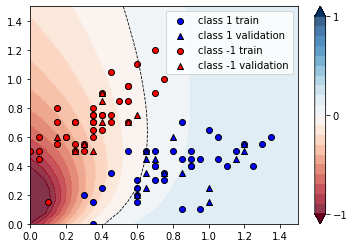

In [21]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(weights, bias, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()